### 导入所有需要用到的库

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import roc_auc_score

### 数据预处理
使用pandas读取csv文件，解析为一个`dataframe`，并做一些处理
- 去掉一些与任务无关的属性
- 把`weight`和`height`转为数值类型
- 将`bust size`排序并转为数值类型
- 将标签`fit`转化为数值类型

In [2]:
df = pd.read_csv('./data/train.txt')
df['body type'].value_counts()

hourglass            38819
athletic             30704
pear                 15579
petite               15502
full bust            10444
straight & narrow    10315
apple                 3397
Name: body type, dtype: int64

In [ ]:
df = df[['weight', 'size', 'rating', 'bust size', 'height', 'fit','body type','age']].copy()

sorted_bust_size = sorted([i for i in df['bust size'].unique() if pd.notna(i)])

weight_map = lambda x: x if pd.isna(x) else float(x[:-3])
height_map = lambda x: x if pd.isna(x) else sum(
    [a * b for a, b in zip([int(i[:-1]) for i in x.split(' ')], [30.48, 2.54])])
bust_size_map = lambda x: x if pd.isna(x) else sorted_bust_size.index(x) + 1



df['weight'] = df['weight'].map(weight_map)
df['height'] = df['height'].map(height_map)
df['bust size'] = df['bust size'].map(bust_size_map)

# df['fit'] = LabelEncoder().fit_transform(df['fit'].astype('category'))
df['fit'] = df['fit'].map({'fit':0,'large':1,'small':2})

In [3]:
df['fit'].value_counts()

0    99542
2    18161
1    17297
Name: fit, dtype: int64

将`train.txt`中的样本分为train和validation两部分

In [4]:
train, test = train_test_split(df, test_size=0.2)
# print(len(train))
# print(len(test))



用平均值填充缺失的数值

In [5]:
train=train.fillna(train.mean())
test=test.fillna(test.mean())

In [6]:
test.head()

,weight,size,rating,bust size,height,fit
100884,137.000000,8,10.0,38.0,180.34,0
7779,118.000000,4,8.0,36.0,162.56,0
7445,137.448418,35,10.0,68.0,175.26,1
113194,140.000000,20,8.0,66.0,167.64,0
95209,137.448418,9,8.0,36.0,167.64,0


转化为`tf.data`

In [7]:
def df_to_dataset(dataframe,shuffle,batch,batch_size):
    dataframe = dataframe.copy()
    labels = dataframe.pop('fit')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe),labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    if batch:
        ds = ds.batch(batch_size)
        ds = ds.prefetch(batch_size)
    return ds

# train_ds = df_to_dataset(train,True)
# [(train_features, label_batch)] = train_ds.take(1)
# val_ds = df_to_dataset(val,False)
# print(train_features['height'])

In [8]:
def one_hot_map(features,label):
    one_hot_label = tf.one_hot(label,depth=3)
    return features,one_hot_label

train_ds = df_to_dataset(train,shuffle=True,batch=True,batch_size=256).map(one_hot_map)
test_ds = df_to_dataset(test,shuffle=False,batch=True,batch_size=256).map(one_hot_map)
# for i in test_ds:
#     print(i)





对数值类型做normalization

In [9]:
def get_normalization_layer(feature, dataset):
    normalizer = preprocessing.Normalization()
    feature_ds = dataset.map(lambda x, y: x[feature])
    normalizer.adapt(feature_ds)
    return normalizer

# photo_count_col = train_features['height']
# layer = get_normalization_layer('height', train_ds)
# layer(photo_count_col)

In [9]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = preprocessing.StringLookup(max_tokens=max_tokens)
    else:
        index = preprocessing.IntegerLookup(max_values=max_tokens)

    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())
    return lambda feature: encoder(index(feature))


In [10]:
# print(train_ds)
# print(len(train_ds))
# print(len(test_ds))
# print(test_ds)


In [11]:
all_inputs = []
encoded_features = []

for header in ['weight', 'size', 'rating', 'bust size', 'height','age']:
    numeric_col = tf.keras.Input(shape=(1,),name=header)
    normalization_layer = get_normalization_layer(header,test_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

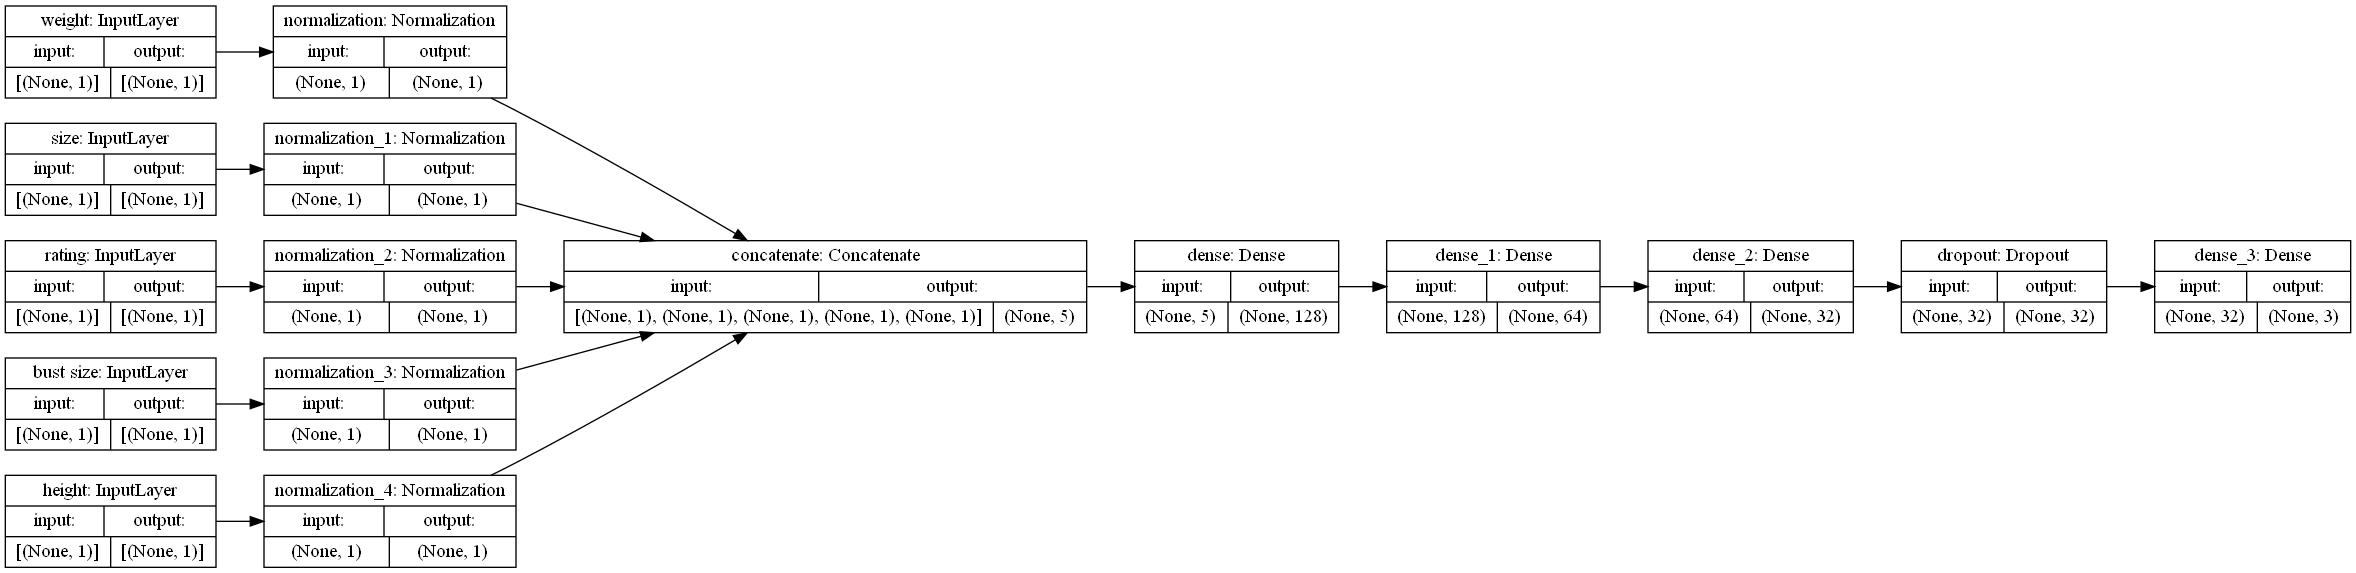

In [12]:
all_features =tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128,activation='relu')(all_features)
x = tf.keras.layers.Dense(64,activation='relu')(x)
x = tf.keras.layers.Dense(32,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(3)(x)
model = tf.keras.Model(all_inputs,output)
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

tf.keras.utils.plot_model(model,show_shapes=True,rankdir='LR')

In [13]:
model.fit(train_ds,epochs=10)

Epoch 1/10
422/422 [==============================] - 1s 2ms/step - loss: 0.7855 - accuracy: 0.7300

KeyboardInterrupt: 

In [ ]:
loss,accuracy = model.evaluate(test_ds)
print(accuracy)

In [ ]:
predictions = model.predict(test_ds)
print(predictions)


In [ ]:
print(tf.nn.softmax(predictions))

In [ ]:
# print(np.argmax(tf.nn.softmax(predictions),axis=1))

In [ ]:
def to_one_hot(a):
    b = np.zeros((a.size, 3))
    b[np.arange(a.size), a] = 1
    return b

In [ ]:
# print(test['fit'])
y_true = test['fit'].to_numpy()

In [ ]:
import random
# y_score = to_one_hot(np.argmax(tf.nn.softmax(predictions),axis=1))
y_score = to_one_hot(np.asarray([random.choice([0,1,2]) for _ in range(len(test))]))

In [ ]:
roc_auc_score(y_true,y_score,multi_class='ovr')